In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import wrangle as wr

from env import get_db_url

# Acquiring Data:
- Acquiring data for *single family homes* that have transaction dates *during the year of 2017.*

In [2]:
query_df = wr.get_zillow_data()

In [3]:
#Verifying that the dataset meets the rubric requirement of being 52,441 homes long:
query_df.shape[0]

52441

## Wrangling Data:
- I readjusted my wrangle function to exclude any homes that are over 1.5 million dollars. 
- This, paired with the other operations and cleaning carried out in the wrangle script, leave 95.4% of the data remaining. 
- I feel comfortable with the omission of this data, as I want to ensure that I'm not excluding too large a chunk of my total set, but do want to be sure that I'm focusing my model on homes that comprise the bulk of Zillow's business. Homes priced in the millions are very clearly not the main focus of Zillow's model, so I don't want to skew it's training by including too many of those. See plot below.

In [4]:
#Acquiring CLEANED data, beyond the initial SQL query:
df = wr.wrangle_zillow()

In [5]:
#Verifying how much of the data was cleaned out (less than 5%):
df.shape[0] / query_df.shape[0]

0.9540435918460747

[Text(0.5, 1.0, 'Distribution of Homes by Price')]

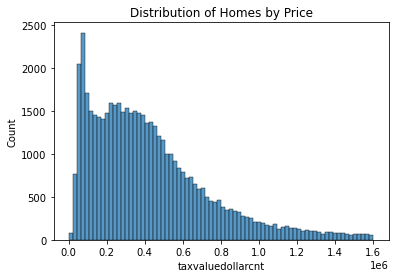

In [7]:
sns.histplot(data = df, x = df.taxvaluedollarcnt).set(title = 'Distribution of Homes by Price')

#It is very clear that the vast majority of homes in Zillow's dataset fall below $1 million. 

# Exploring Data:

In [9]:
# splitting the data into train, validate, and test sets before exploration:
train, validate, test = wr.split_zillow_data(df)

[Text(0.5, 1.0, 'Distribution of Homes by Price')]

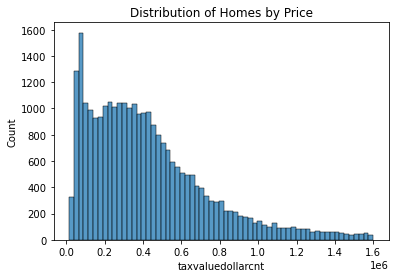

In [10]:
sns.histplot(data = train, x = train.taxvaluedollarcnt).set(title = 'Distribution of Homes by Price')